In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import sklearn

# Data

In [65]:
data, labels = sklearn.datasets.load_iris()['data'], sklearn.datasets.load_iris()['target']

data = torch.tensor(data, dtype = torch.float)
labels = torch.tensor(labels, dtype = torch.long)

data.shape, labels.shape

(torch.Size([150, 4]), torch.Size([150]))

# Preprocessing

In [68]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size = .8)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# We pack it up for batch experiments
def train_dataloader_fn(batch_size):
  train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
  return train_dataloader

test_dataloader = DataLoader(test_dataset, batch_size = X_test.shape[0])

# Model Arch

In [76]:
class ModelArch(nn.Module):
  def __init__(self):
    super().__init__()

    self.input = nn.Linear(4, 128)
    self.hidden = nn.Linear(128, 128)
    self.output = nn.Linear(128, 3)

  def forward(self, x):
    x = self.input(x)
    x = F.relu(x)

    x = self.hidden(x)
    x = F.relu(x)

    x = self.output(x)

    return x

# Model Setup

In [77]:
def ModelSetup():
  ann = ModelArch()
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(ann.parameters(), lr = 1e-3)

  return ann, loss_fn, optimizer

# Model Test

In [82]:
ann, loss_fn, optimizer = ModelSetup()
temp_data = torch.randn(1000, 4)
temp_y_hat = ann(temp_data)
torch.argmax(temp_y_hat, axis = 1)[:100]

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0])

# Model Train

In [91]:
def train(epochs, batch_size):
  ann, loss_fn, optimizer = ModelSetup()
  train_dataloader = train_dataloader_fn(batch_size)

  train_accs = torch.zeros(epochs)
  test_accs = torch.zeros(epochs)
  train_losses = torch.zeros(epochs)
  test_losses = torch.zeros(epochs)

  for epoch in range(epochs):
    ann.train()

    batch_accs = torch.zeros(len(train_dataloader))
    batch_losses = torch.zeros(len(train_dataloader))

    for batch, (X_train, y_train) in enumerate(train_dataloader):
      batch_y_hat = ann(X_train)

      batch_loss = loss_fn(batch_y_hat, y_train)
      batch_losses[batch] = batch_loss

      batch_acc = 100 * torch.mean(
         (torch.argmax( batch_y_hat, axis = 1 ) == y_train).float()
      )
      batch_accs[batch] = batch_acc

      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    train_accs[epoch] = torch.mean(batch_accs)
    train_losses[epoch] = torch.mean(batch_losses)

    ann.eval()

    X_test, y_test = next(iter(test_dataloader))
    test_y_hat = ann(X_test)

    test_loss = loss_fn(test_y_hat, y_test)
    test_losses[epoch] = test_loss

    test_acc = 100 * torch.mean(
        (torch.argmax( test_y_hat, axis = 1 ) == y_test).float()
    )
    test_accs[epoch] = test_acc

    if epoch%10 == 0:
      print(f'Epoch: {epoch} | Train -> Acc: {train_accs[epoch]:2f} Loss: {train_losses[epoch]:2f} | Test -> Acc: {test_acc:2f} Loss: {test_loss:2f}')

  return train_accs, test_accs, train_losses, test_losses

# Model Train Test

In [92]:
train_accs, test_accs, train_losses, test_losses = train(epochs = 500, batch_size = 32)

Epoch: 0 | Train -> Acc: 32.552086 Loss: 1.065600 | Test -> Acc: 46.666668 Loss: 0.988762
Epoch: 10 | Train -> Acc: 34.375000 Loss: 0.992159 | Test -> Acc: 30.000002 Loss: 0.984507
Epoch: 20 | Train -> Acc: 63.281250 Loss: 0.955957 | Test -> Acc: 53.333336 Loss: 0.969381
Epoch: 30 | Train -> Acc: 70.052078 Loss: 0.915007 | Test -> Acc: 53.333336 Loss: 0.945055
Epoch: 40 | Train -> Acc: 69.270836 Loss: 0.883933 | Test -> Acc: 53.333336 Loss: 0.916552
Epoch: 50 | Train -> Acc: 70.052078 Loss: 0.845740 | Test -> Acc: 53.333336 Loss: 0.896155
Epoch: 60 | Train -> Acc: 70.572922 Loss: 0.812465 | Test -> Acc: 53.333336 Loss: 0.869625
Epoch: 70 | Train -> Acc: 70.312500 Loss: 0.780424 | Test -> Acc: 53.333336 Loss: 0.844510
Epoch: 80 | Train -> Acc: 70.052078 Loss: 0.748049 | Test -> Acc: 53.333336 Loss: 0.816113
Epoch: 90 | Train -> Acc: 70.052078 Loss: 0.717434 | Test -> Acc: 53.333336 Loss: 0.789677
Epoch: 100 | Train -> Acc: 69.791672 Loss: 0.688711 | Test -> Acc: 53.333336 Loss: 0.765233

# Plot Model Train Test

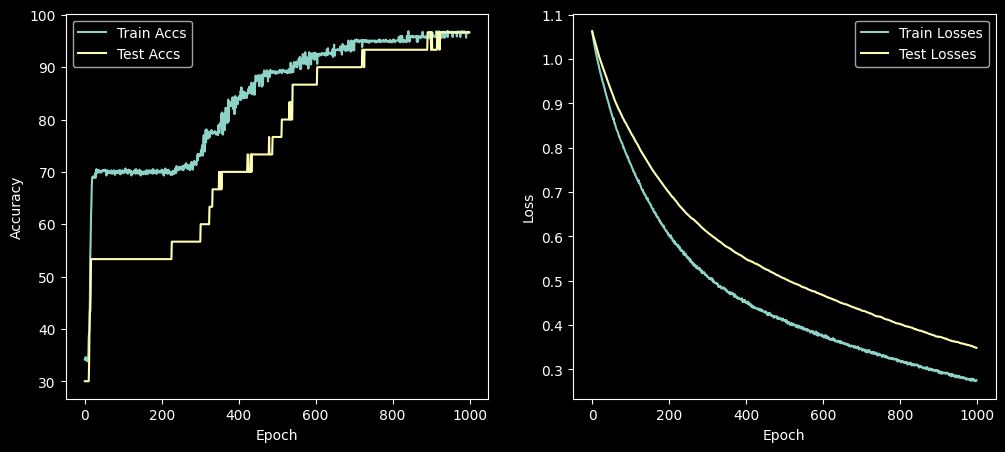

In [127]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

ax[0].plot(train_accs, label = 'Train Accs')
ax[0].plot(test_accs, label = 'Test Accs')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend()

ax[1].plot(train_losses.detach(), label = 'Train Losses')
ax[1].plot(test_losses.detach(), label = 'Test Losses')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend()

# Batch Size Experiment

In [103]:
batch_sizes = [2**i for i in range(1,7)]
epochs = 1000

exp_batch_train_accs = torch.zeros(epochs, len(batch_sizes))
exp_batch_test_accs = torch.zeros(epochs, len(batch_sizes))

for i in range(len(batch_sizes)):
  print(f'\n\nPROCESSING BATCH_SIZE = {batch_sizes[i]}')

  train_accs, test_accs, train_losses, test_losses = train(epochs = epochs, batch_size = batch_sizes[i])

  exp_batch_train_accs[:, i] = train_accs
  exp_batch_test_accs[:, i] = test_accs



PROCESSING BATCH_SIZE = 2
Epoch: 0 | Train -> Acc: 35.833332 Loss: 1.065219 | Test -> Acc: 30.000002 Loss: 1.038071
Epoch: 10 | Train -> Acc: 78.333336 Loss: 0.565511 | Test -> Acc: 56.666668 Loss: 0.658291
Epoch: 20 | Train -> Acc: 89.166664 Loss: 0.409890 | Test -> Acc: 90.000000 Loss: 0.485862
Epoch: 30 | Train -> Acc: 91.666664 Loss: 0.327203 | Test -> Acc: 96.666664 Loss: 0.395751
Epoch: 40 | Train -> Acc: 96.666664 Loss: 0.269886 | Test -> Acc: 96.666664 Loss: 0.331398
Epoch: 50 | Train -> Acc: 95.833336 Loss: 0.221775 | Test -> Acc: 96.666664 Loss: 0.275690
Epoch: 60 | Train -> Acc: 98.333336 Loss: 0.188103 | Test -> Acc: 96.666664 Loss: 0.252458
Epoch: 70 | Train -> Acc: 97.500000 Loss: 0.164518 | Test -> Acc: 96.666664 Loss: 0.221712
Epoch: 80 | Train -> Acc: 97.500000 Loss: 0.140283 | Test -> Acc: 96.666664 Loss: 0.191369
Epoch: 90 | Train -> Acc: 97.500000 Loss: 0.124304 | Test -> Acc: 96.666664 Loss: 0.179651
Epoch: 100 | Train -> Acc: 98.333336 Loss: 0.114406 | Test -> A

# Plot Batch Size Experiment

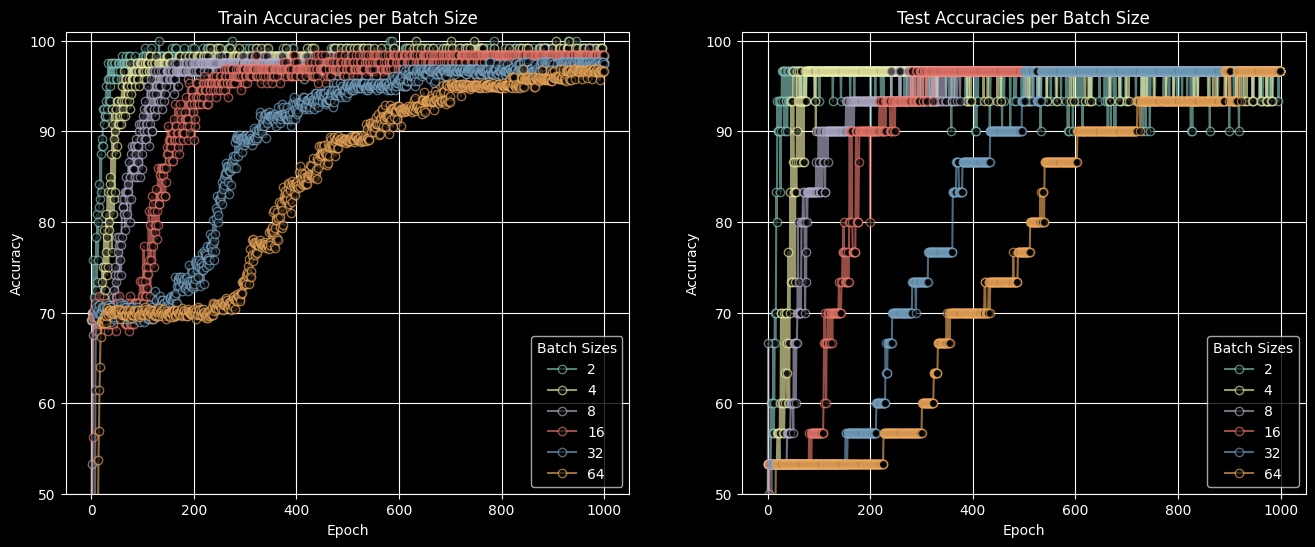

In [126]:
fig, ax = plt.subplots(1, 2, figsize = (16, 6))

plt.style.use('dark_background')

ax[0].plot(exp_batch_train_accs, '-o', markerfacecolor = 'k', alpha = .6)
ax[0].set_title('Train Accuracies per Batch Size')

ax[1].plot(exp_batch_test_accs, '-o', markerfacecolor = 'k', alpha = .6)
ax[1].set_title('Test Accuracies per Batch Size')

labels = [str(i) for i in batch_sizes]

for i in range(2):
  ax[i].legend(labels, title = 'Batch Sizes')
  ax[i].set_ylabel('Accuracy')
  ax[i].set_xlabel('Epoch')
  ax[i].grid()
  ax[i].set_ylim([50, 101])

plt.show()

We can see graduall decrease of speed of learning proportional to increase of the batch_size.